In [59]:
import pandas as pd
import numpy as np
# https://www.kaggle.com/code/carlmcbrideellis/feature-selection-using-the-boruta-shap-package
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

In [37]:
data = pd.read_csv("data_with_new_features.csv")
features = pd.read_csv('feature_importances_xgb.csv', nrows = 20)
features.head()
selected_features = list[features['Unnamed: 0'].values]
selected_features

list[array(['months_employed', 'credit_score', 'age', 'interest_rate',
       'credit_age_factor', 'dtiratio', 'interest_payment_burden',
       'income_to_interest_ratio', 'credit_income_inter',
       'income_to_loan_ratio', 'loan_pay_to_inc_ratio', 'loan_amount',
       'empl_sta', 'credit_util_ratio', 'income', 'has_co_signer=No',
       'employment_type=Full-time', 'loan_term',
       'employment_type=Unemployed', 'has_dependents=No'], dtype=object)]

In [38]:
data_new = data.copy()
y = data_new["default"]
del data_new["default"]

data_new = data_new[selected_features]

In [39]:
df_full_train, df_test, y_full_train, y_test = train_test_split(data_new, y, stratify = y, test_size = 0.2, random_state = 1)

df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, stratify =y_full_train,  test_size = 0.25, random_state = 1)

In [40]:
df_full_train = df_full_train.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [41]:
y_full_train = y_full_train.values
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

In [42]:
full_train_dicts = df_full_train.to_dict(orient = 'records')
train_dicts = df_train.to_dict(orient = 'records')
val_dicts = df_val.to_dict(orient = 'records')
test_dicts = df_test.to_dict(orient = 'records')

In [43]:
# I was getting a memory error, so I set sparse=True for the DictVectorizer.
dv = DictVectorizer(sparse = True)
dv.fit(train_dicts)
X_full_train_new = dv.transform(full_train_dicts)
X_train_new = dv.transform(train_dicts)
X_val_new = dv.transform(val_dicts)
X_test_new = dv.transform(test_dicts)

In [44]:



from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_full_train)

In [10]:
# fit model no training data
model = XGBClassifier(params = {'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 1,'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 5,
'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}, objective="binary:logistic", feature_name=dv.get_feature_names_out(), random_state = 1)
model.fit(X_full_train_new, y_full_train,sample_weight=sample_weights)

C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_name=array(['age', 'credit_age_factor', 'credit_income_inter', ...,
       'marital_status_dependents=Single_Yes', 'months_employed',
       'num_credit_lin...
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred = model.predict_proba(X_test_new)[:,1]

In [12]:
print(y_pred)

[0.75899124 0.67681766 0.54432464 ... 0.37157747 0.14638917 0.1884372 ]


In [13]:
y_pred > 0.5
y_decision = (y_pred >= 0.5).astype(int)
acc = (y_test == y_decision).mean().round(2)
print(f"Accuracy is calculated as \033[1m{acc}\033[0m.")
f_macro = f1_score(y_test, y_decision, average='macro').round(2)
print(f"Macro F1 score is calculated as \033[1m{f_macro}\033[0m.")
f_weighted = f1_score(y_test, y_decision, average='weighted').round(2)
print(f"Weighted F1 score is calculated as \033[1m{f_weighted}\033[0m.")

Accuracy is calculated as 0.71.
Macro F1 score is calculated as 0.58.
Weighted F1 score is calculated as 0.76.


In [14]:
seeds = [5, 13, 29, 43, 57, 87, 29, 42,1, 93]

In [32]:
#I initiannly get same results for each run. I tried the change subsample, colsample_bytree parameters but it did not help.
#To devaluate non deterministic results I st booster to gblinear readinf the xgboost documentation 
#https://readthedocs.org/projects/xgboost/downloads/pdf/latest/

results = []
for i in [5, 13, 29, 43, 57, 87, 28, 42,1, 93]:
    print(i)
    # I have deleted subsample and colsample_bytree parameters since I have evaluated same result at each run
    model = XGBClassifier(params = {'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 1,'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 5,
'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}, objective="binary:logitraw", feature_selector= "shuffle", booster = 'gblinear',
                          feature_name=dv.get_feature_names_out(), random_state = i)
    model.fit(X_full_train_new, y_full_train,sample_weight=sample_weights)
    y_pred = model.predict_proba(X_test_new)[:,1]
    y_pred > 0.5
    y_decision = (y_pred >= 0.5).astype(int)
    acc = (y_test == y_decision).mean().round(4)
    print(f"Accuracy is calculated as \033[1m{acc}\033[0m.")
    f_macro = f1_score(y_test, y_decision, average='macro').round(4)
    print(f"Macro F1 score is calculated as \033[1m{f_macro}\033[0m.")
    f_weighted = f1_score(y_test, y_decision, average='weighted').round(4)
    print(f"Weighted F1 score is calculated as \033[1m{f_weighted}\033[0m.")
    results.append((acc,f_macro,f_weighted))
    output_file = f'modelxgb_i={i}.bin'
    with open(output_file, 'wb') as f_out:
        pickle.dump((dv, model), f_out)
    

5


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7997.
Macro F1 score is calculated as 0.6242.
Weighted F1 score is calculated as 0.8214.
13


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.8004.
Macro F1 score is calculated as 0.6245.
Weighted F1 score is calculated as 0.8218.
29


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7996.
Macro F1 score is calculated as 0.6242.
Weighted F1 score is calculated as 0.8213.
43


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7995.
Macro F1 score is calculated as 0.6241.
Weighted F1 score is calculated as 0.8212.
57


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7994.
Macro F1 score is calculated as 0.6242.
Weighted F1 score is calculated as 0.8212.
87


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.8004.
Macro F1 score is calculated as 0.6246.
Weighted F1 score is calculated as 0.8218.
28


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7999.
Macro F1 score is calculated as 0.624.
Weighted F1 score is calculated as 0.8214.
42


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.8002.
Macro F1 score is calculated as 0.6246.
Weighted F1 score is calculated as 0.8217.
1


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7998.
Macro F1 score is calculated as 0.6245.
Weighted F1 score is calculated as 0.8215.
93


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7999.
Macro F1 score is calculated as 0.6244.
Weighted F1 score is calculated as 0.8215.


In [49]:
import pickle

from flask import Flask
from flask import request
from flask import jsonify


model_file1 = 'modelxgb_i=5.bin'

with open(model_file1, 'rb') as f_in:
    dv1, model1 = pickle.load(f_in)

est1 = model1.predict_proba(X_test_new)

model_file2 = 'modelxgb_i=13.bin'

with open(model_file2, 'rb') as f_in:
    dv2, model2 = pickle.load(f_in)

est2 = model2.predict_proba(X_test_new)

model_file3 = 'modelxgb_i=29.bin'

with open(model_file3, 'rb') as f_in:
    dv3, model3 = pickle.load(f_in)

est3 = model3.predict_proba(X_test_new)


model_file4 = 'modelxgb_i=43.bin'

with open(model_file4, 'rb') as f_in:
    dv4, model4 = pickle.load(f_in)

est4 = model4.predict_proba(X_test_new)


model_file5 = 'modelxgb_i=57.bin'

with open(model_file5, 'rb') as f_in:
    dv5, model5 = pickle.load(f_in)

est5 = model5.predict_proba(X_test_new)



model_file6 = 'modelxgb_i=87.bin'

with open(model_file6, 'rb') as f_in:
    dv6, model6 = pickle.load(f_in)

est6 = model6.predict_proba(X_test_new)


model_file7 = 'modelxgb_i=28.bin'

with open(model_file7, 'rb') as f_in:
    dv7, model7 = pickle.load(f_in)

est7 = model7.predict_proba(X_test_new)


model_file8 = 'modelxgb_i=42.bin'

with open(model_file8, 'rb') as f_in:
    dv8, model8 = pickle.load(f_in)

est8 = model8.predict_proba(X_test_new)


model_file9 = 'modelxgb_i=1.bin'

with open(model_file9, 'rb') as f_in:
    dv9, model9 = pickle.load(f_in)

est9 = model9.predict_proba(X_test_new)

model_file10 = 'modelxgb_i=93.bin'

with open(model_file10, 'rb') as f_in:
    dv10, model10 = pickle.load(f_in)

est10 = model10.predict_proba(X_test_new)

In [56]:
list_models = np.array([est1, est2, est3, est4, est5, est6, est7, est8, est9, est10])
averages = np.average(list_models, axis=0)


Accuracy is calculated as 0.8.
Macro F1 score is calculated as 0.6244.
Weighted F1 score is calculated as 0.8216.


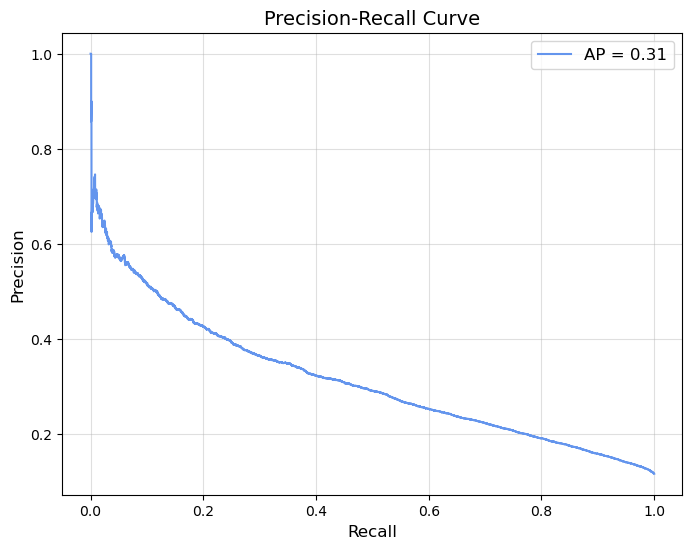

In [67]:
y_pred_proba = est1
y_pred =averages[:,1]
y_pred > 0.5
y_decision = (y_pred >= 0.5).astype(int)
acc = (y_test == y_decision).mean().round(4)
print(f"Accuracy is calculated as \033[1m{acc}\033[0m.")
f_macro = f1_score(y_test, y_decision, average='macro').round(4)
print(f"Macro F1 score is calculated as \033[1m{f_macro}\033[0m.")
f_weighted = f1_score(y_test, y_decision, average='weighted').round(4)
print(f"Weighted F1 score is calculated as \033[1m{f_weighted}\033[0m.")
results.append((acc,f_macro,f_weighted))

# Calculate precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color = "cornflowerblue")
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.4)
plt.show()
